# 🤒 Epidemic mitigation project

### Importing the relevant packages

In [14]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


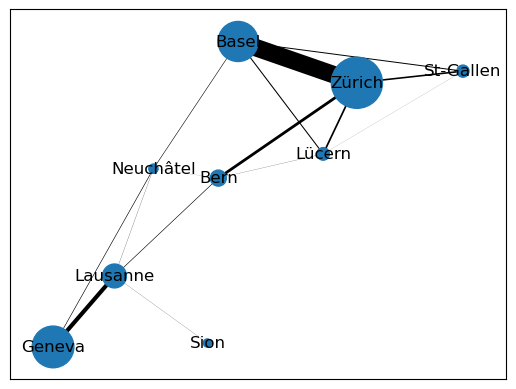

In [15]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

### Question 1.a) study the behavior of the model when epidemics are unmitigated.

Running the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is
taken, i.e. all values in the action dictionary are set to False).

sampled action : 1
Sampled observation


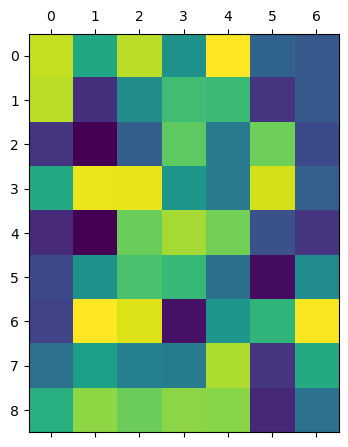

In [16]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

In [17]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [34]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    action = 0
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

C:\Users\Daria\AppData\Local\Temp\ipykernel_31840\937037881.py:11: RuntimeWarning: divide by zero encountered in log
  [ax_leftstate.plot(np.log(y)) for y in total.values()]


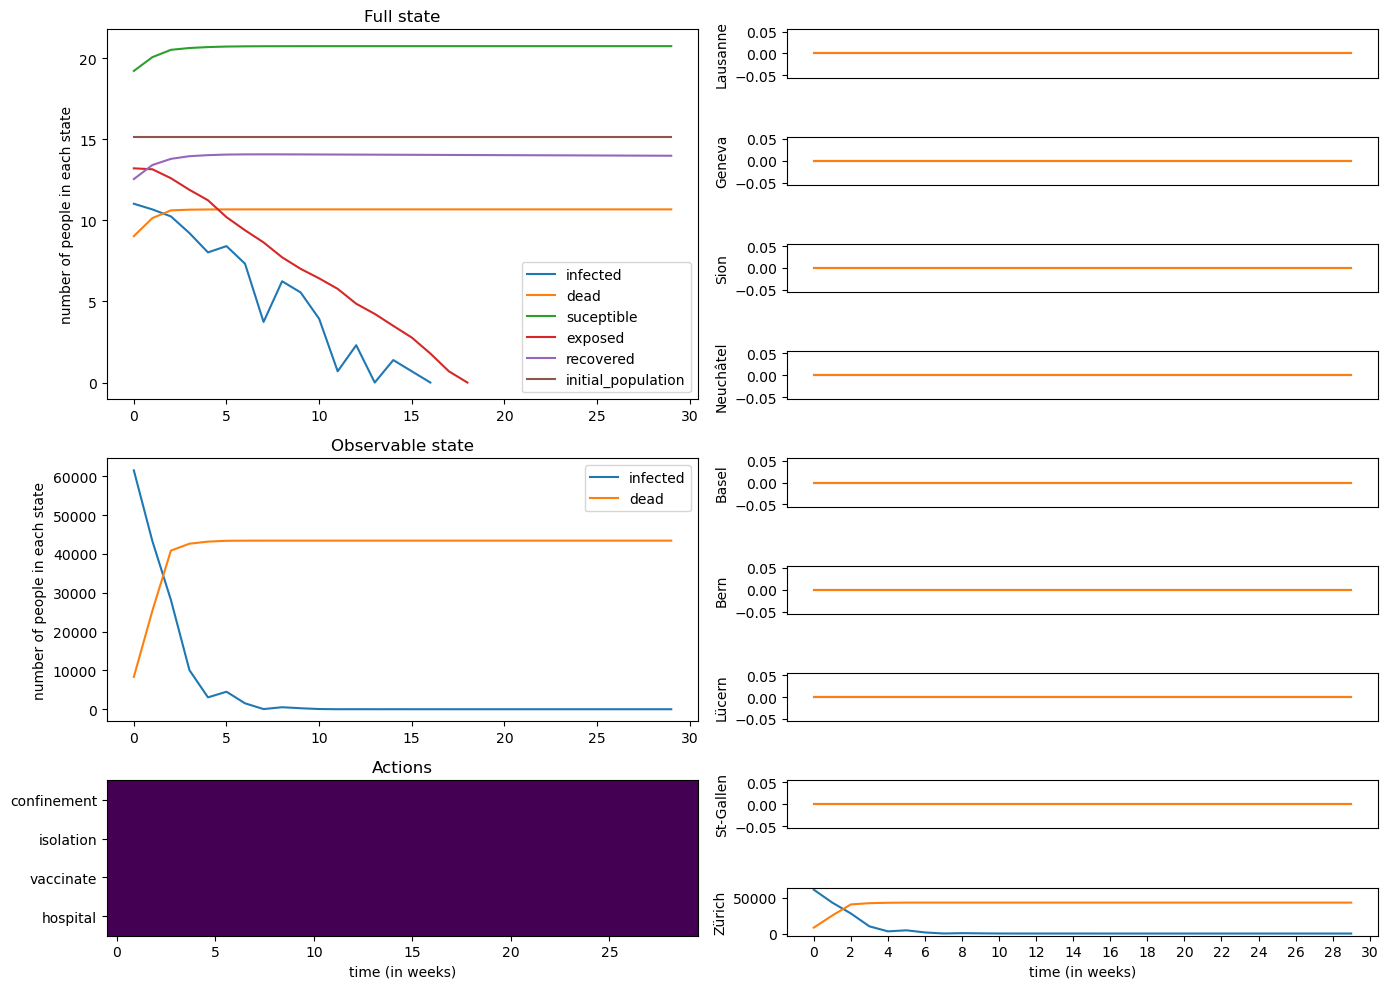

In [35]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(np.log(y)) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

In [98]:
class RussoAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.count_confinement = 0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in self.env.dyn.parameters}
        if len(total['infected']) != 0:
            if (total['infected'][-1]) >= 20000 and self.count_confinement == 0:
                self.count_confinement += 1
                return 1
        if self.count_confinement == 4:
            self.count_confinement = 0
        if self.count_confinement != 0:
            self.count_confinement += 1
            return 1
        return 0

In [99]:
agent = RussoAgent(env)
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    # print(action)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

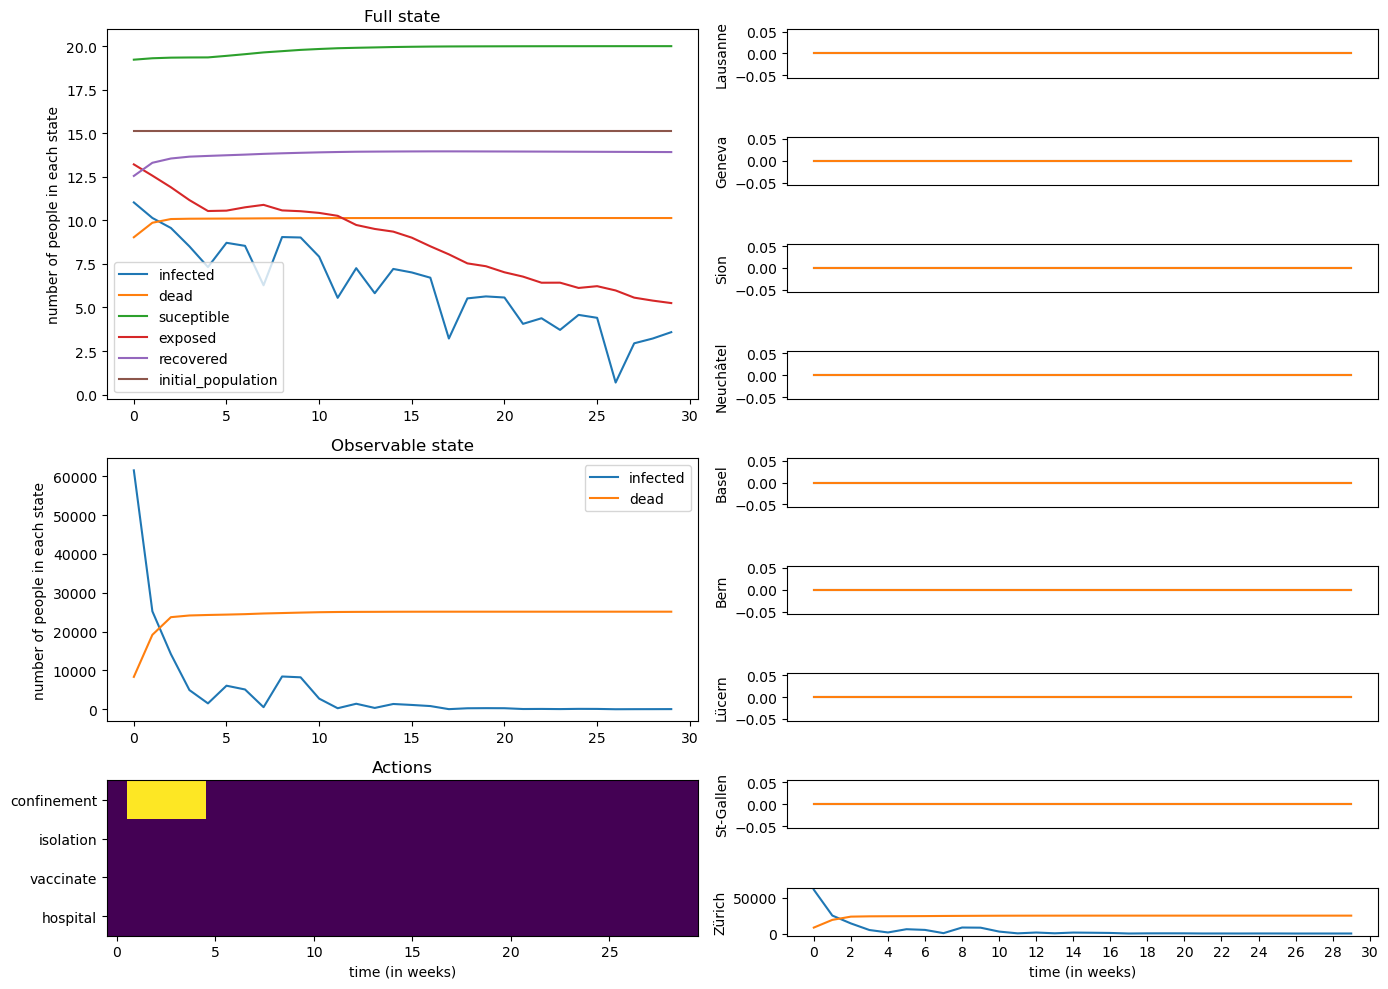

In [100]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(np.log(y)) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

In [ ]:
agent = RussoAgent(env)
log = []
for _ in range(50):
    finished = False
    obs, info = env.reset(2)
    agent.reset()
    agent.epsilon = 0
    n_weeks_confined = 0
    while not finished:
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        if finished:
            break
        
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}